In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

## Load the data

Each row contains readings from the LDR for each color of LED for a specific slot & tile color combination.

In [2]:
df = pd.read_csv("data/data_201912081148.csv", names = ['slot','off','r','g','b','tile_color'])
df.head()

,slot,off,r,g,b,tile_color
0,0,0,576,537,212,Red
1,1,0,749,635,318,Red
2,2,0,770,588,249,Red
3,3,0,734,622,295,Red
4,4,5,615,382,398,Green


## Normalise for each slot

Some slots are brighter than others - and brighter in specific colors. This is probably due partly to variation in the LDRs and partly to differences in the exact position of the RGB leds relative to the windows. 

To adjust for this, we compute the mean brightness for each LED for each slot, and subtract this from the measured RGB values.

In [3]:
# difference to mean for that color LED for that slot
df['dr'] = df.r - df.groupby('slot').r.transform('mean') 
df['dg'] = df.g - df.groupby('slot').g.transform('mean')
df['db'] = df.b - df.groupby('slot').b.transform('mean')

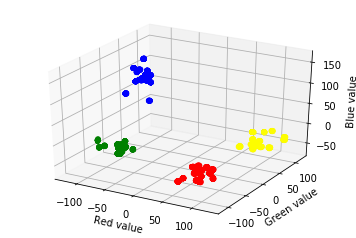

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['dr'],df['dg'] , df['db'],c=df['tile_color'])
ax.set_xlabel('Red value')
ax.set_ylabel('Green value')
ax.set_zlabel('Blue value');

In [51]:
centers = df.groupby('tile_color')['dr','dg','db'].mean().round().astype(int)
average_brightness = df.groupby('slot')['r','g','b'].mean().round().astype(int)

,dr,dg,db
tile_color,,,
Blue,-75,14,114
Green,-91,-31,-40
Red,72,-62,-43
Yellow,94,78,-31


## Copy data into Arduino script

In the Arduino script, we will identify the color of the tile by;
   - reading the RGB values for a slot
   - subtracting the average brightness for that slot
   - finding the color center point that is closest to that difference vector

In [90]:
def dataframe_to_cstring(df, array_name, array_type = 'int'):
    """Return a pandas dataframe out as a c style array string"""
    rows, columns = df.shape
    c_code = "{0} {1}[{2}][{3}] = {{\n".format(array_type, array_name, rows, columns)
    for index, row in df.iterrows():
        row_str = [str(x) for x in row]
        c_code += '   {'+",".join(row_str)+"},\n"
    c_code += '};\n'
            
    return c_code

In [ ]:
{'Blue': [-75, 14, 114],
 'Green': [-91, -31, -40],
 'Red': [72, -62, -43],
 'Yellow': [94, 78, -31]}

In [91]:
print(dataframe_to_cstring(centers,'centers'))
print(dataframe_to_cstring(average_brightness,'average_brightness'))

int centers[4][3] = {
   {-75,14,114},
   {-91,-31,-40},
   {72,-62,-43},
   {94,78,-31},
};

int average_brightness[16][3] = {
   {507,588,255},
   {684,686,365},
   {709,643,295},
   {652,670,342},
   {694,410,420},
   {625,439,460},
   {696,508,496},
   {590,361,339},
   {710,606,282},
   {651,661,333},
   {627,663,366},
   {660,632,309},
   {615,520,90},
   {650,661,304},
   {715,699,371},
   {681,559,277},
};



## Test out the code for generating c code with no numpy/pandas dependancies

In [5]:
from utils import read_results, group_data, apply_to_group, compute_normed_centers, mean, dict_of_lists_to_cstring
data = read_results("data/data_201912081148.csv")

g = group_data(data,[2,3,4],[0],lambda k: "{:02d}".format(int(k)))
average_brightness = apply_to_group(g, mean,lambda x: int(round(x)))
centers = compute_normed_centers(data,average_brightness)

In [6]:
print(dict_of_lists_to_cstring(average_brightness, sorted(average_brightness.keys()),'average_brightness','int'))
print(dict_of_lists_to_cstring(centers, ['Blue','Green','Red','Yellow'],'centers','int'))

int average_brightness[16][3] = {
   {507,588,256},
   {684,687,365},
   {709,643,295},
   {652,670,342},
   {694,410,420},
   {625,439,460},
   {696,508,496},
   {590,361,339},
   {710,606,282},
   {651,661,333},
   {627,663,366},
   {660,632,309},
   {615,520,90},
   {650,661,304},
   {715,699,371},
   {681,559,277},
};

int centers[4][3] = {
   {-75,14,114},
   {-91,-31,-40},
   {72,-62,-43},
   {94,78,-31},
};

